In [13]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from scipy.spatial.distance import cdist
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

np.random.seed(21)

In [2]:
means = [[2, 2], [4, 1]]
cov = [[.3, .2], [.2, .3]]
N = 100
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
X0[-1, :] = [4.5, 1.2]
X = np.concatenate((X0.T, X1.T), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)

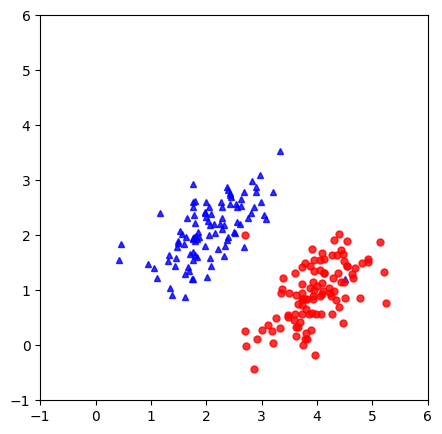

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ani = plt.cla()
#plot points
ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8)
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8)
ani = plt.axis([-1 , 6, -1, 6])
plt.show()

### Bài toán ràng buộc

In [ ]:
C = 100
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
# K ~ P in lib cvxopt.qp
K = matrix(V.T.dot(V))

q = matrix(-np.ones((2*N, 1)))
# build A, b, G, h
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N)))
b = matrix(np.zeros((1, 1)))
solvers.options['show_progress'] = False
sol = solvers.qp(K, q, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[2.18955004e-08 4.84181238e-08 2.58111529e+01 2.37911252e-08
  1.95738969e-08 1.19804345e-08 2.70655192e-08 2.56140559e-08
  1.78887349e-08 2.10448956e-08 5.00017695e-08 9.99999990e+01
  1.93376368e-08 1.38098929e-08 1.50693518e-08 1.21136359e-08
  7.13945086e+01 1.21997851e-08 1.35494953e-08 1.81157564e-08
  1.81084856e-08 1.05030805e-08 2.69537483e-08 4.80151283e-08
  8.71541482e-08 1.47237173e-08 1.53795653e-08 1.49561180e-08
  1.20423454e-08 1.09304466e-08 1.44332415e-08 2.70134059e-08
  1.34362730e-08 2.24332293e-08 1.54527054e-08 1.79328848e-08
  1.61078576e-07 8.45050292e-09 8.57949716e-09 2.72318461e-08
  4.42248659e-08 1.84795368e-08 1.44190070e-08 1.39005335e-08
  4.41891223e-08 5.70901194e-08 1.03458235e-08 1.69037185e-08
  8.89421826e-09 5.18374275e-08 3.06528399e-08 1.64750271e-08
  1.46587526e-08 1.48942040e-08 4.66157897e-08 1.80565701e-08
  4.35399908e-08 4.48252489e-08 2.55017600e-08 4.78086000e-08
  1.32432988e-08 1.91342196e-08 3.57399267e-08 2.28847737e-

In [8]:
S = np.where(l > 1e-5)[0] # support set
S2 = np.where(l < .999*C)[0]

M = list(int(val) for val in S if val in S2) # intersection of two lists

XT = X.T # we need each column to be one data point in this alg
VS = V[:, S]
lS = l[S]
yM = y[0][M]
XM = XT[M, :]

w_dual = VS.dot(lS).reshape(-1, 1)
b_dual = np.mean(yM - XM.dot(w_dual))
print(w_dual.T, b_dual)

[[-1.42831153  1.45023448]] 2.0656712488943185


In [15]:
def predict(b, w, X):
    return np.sign(w.T @ X + b).flatten()

In [22]:
y_pred_dual = predict(b_dual, w_dual, X)
y_true = y.flatten()

print("Accuracy Score:", accuracy_score(y_true, y_pred_dual))
print("Confusion Matrix:", confusion_matrix(y_true, y_pred_dual))

Accuracy Score: 0.99
Confusion Matrix: [[99  1]
 [ 1 99]]


### Bài toán không ràng buộc

In [9]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data
Z = np.hstack((X0_bar, - X1_bar)) # as in (22)

lam = 1./C

def cost(w):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] # no bias
def grad(w):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1] # no weight decay on bias
    return g

eps = 1e-6

In [10]:
def grad_descent(w0, eta):
    w = w0
    it = 0
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break
    return w

In [11]:
w0 = np.random.randn(X0_bar.shape[0], 1)
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

C:\Users\MY PC\AppData\Local\Temp\ipykernel_26956\2275045128.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('iter %d' %it + ' cost: %f' %cost(w))


iter 1 cost: 832.954650
iter 10001 cost: 5.932562
iter 20001 cost: 5.924600
iter 30001 cost: 5.924484
iter 40001 cost: 5.924364
iter 50001 cost: 5.931944
iter 60001 cost: 5.925364
iter 70001 cost: 5.925248
iter 80001 cost: 5.924290
iter 90001 cost: 5.924485
[[-1.41988542  1.44001227]] [2.0637578]


In [17]:
y_pred_hinge = predict(b_hinge, w_hinge, X)

print("Accuracy Score:", accuracy_score(y_true, y_pred_hinge))
print("Confusion Matrix:", confusion_matrix(y_true, y_pred_hinge))

Accuracy Score: 0.99
Confusion Matrix: [[99  1]
 [ 1 99]]


### Sử dụng sklearn

In [12]:
# Copy and put code for generate data here
y1 = y.reshape((2*N,))
X1 = X.T # each sample is one row
clf = SVC(kernel = 'linear', C = 100) # use the same C
# if C is small, method will be “SoftMagin SVM”,
# if C is large enough, method is near to hard margin
clf.fit(X1, y1)

w = clf.coef_
w0 = clf.intercept_
print('w = ', w)
print('b = ', w0)

w =  [[-1.42778364  1.44987365]]
b =  [2.06475458]


In [20]:
y_pred = clf.predict(X.T)

print("Accuracy Score:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:", confusion_matrix(y_true, y_pred))

Accuracy Score: 0.99
Confusion Matrix: [[99  1]
 [ 1 99]]


### C = 1000

In [29]:
c_list = [1000, 200, 10, 0.5]

for c in c_list:
    print(f"\n--------------C = {c}--------------")
    y1 = y.reshape((2*N,))
    X1 = X.T 
    clf = SVC(kernel = 'linear', C = c) 
    # if C is small, method will be “SoftMagin SVM”,
    # if C is large enough, method is near to hard margin
    clf.fit(X1, y1)

    w = clf.coef_
    w0 = clf.intercept_
    print('w = ', w)
    print('b = ', w0)
    
    y_pred = clf.predict(X.T)

    print("Accuracy Score:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:", confusion_matrix(y_true, y_pred))


--------------C = 1000--------------
w =  [[-1.42706137  1.45148718]]
b =  [2.06017003]
Accuracy Score: 0.99
Confusion Matrix: [[99  1]
 [ 1 99]]

--------------C = 200--------------
w =  [[-1.4275913   1.45062282]]
b =  [2.06302265]
Accuracy Score: 0.99
Confusion Matrix: [[99  1]
 [ 1 99]]

--------------C = 10--------------
w =  [[-1.31258548  1.33275939]]
b =  [1.97921644]
Accuracy Score: 0.99
Confusion Matrix: [[99  1]
 [ 1 99]]

--------------C = 0.5--------------
w =  [[-1.26577876  1.12483886]]
b =  [2.11317636]
Accuracy Score: 0.99
Confusion Matrix: [[99  1]
 [ 1 99]]


Accuracy Score: 0.99
Confusion Matrix: [[99  1]
 [ 1 99]]
